# Musical Instrument Recognition with Spectral Vectors and K-Means

Source: http://www.philharmonia.co.uk/explore/sound_samples/

In [1]:
# Capture Sound Samples

import numpy as np
from scipy import signal
import scipy.io.wavfile as sp
import os

#class that represents an instrument playing a specific note and its segments
class Instrument:
    def __init__(self, name, data, rate, segments):
        self.name = name             # instrument name
        self.data = data             # raw waves for the audio
        self.rate = rate             # sampling rate for the audio
        self.segments = segments     # segmented waves after fourier transform
        
#dictionary of the instruments
instruments = []
        
#iterate through all instrument folders in wav_data
directory = "data/wav_data/"
for folder in os.listdir(directory):
    if "." not in folder:
        #create an instrument object with the appropriate name per folder
        new_instrument = Instrument(folder, [], [], [])
        #iterate through all .wav files in folders
        for file_path in os.listdir(directory + folder):
            if file_path.endswith(".wav"):
                #rate = frames per second, data = the frames
                rate, data = sp.read(directory + folder + "/" + file_path)
                #append the data and rate for the sample
                new_instrument.data.append(data)
                new_instrument.rate.append(rate)
        #add instrument to instruments list
        instruments.append(new_instrument)   
        #print that new instrument was added
        print(new_instrument.name, 'added')
    
print('FINISHED')

banjo added
bass_clarinet added
bass_drum added
cello added
clash_cymbals added
cowbell added
double_bass added
flute added
french_horn added
guitar added
oboe added
saxophone added
snare_drum added
tambourine added
triangle added
trombone added
trumpet added
tuba added
viola added
violin added
FINISHED


## Feature Extraction
- Regularize to mean volume
- Get short time fourier transform
- Convert Segments into Spectral Vectors

In [2]:
#scale the volume for all the audio samples

#find mean volume of sound samples 
lists_of_tops = [[np.max(sample) for sample in instrument.data] for instrument in instruments]
list_of_tops = [top for list_of_tops in lists_of_tops for top in list_of_tops]
mean_volume = np.mean(list_of_tops)

def scale_volume(data, avg_volume = mean_volume):
    final_scale = avg_volume / (max(-1 * min(data), max(data)))
    return data * final_scale

# Short Time Fourier Transform Method
def stft_custom(x, fs, framesz=0.025, hop=0.01):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)

    # If multi-channel, keep first
    if np.size(np.matrix(x),0) > 1:
        print('multichannel')
        x = x[:,0]
    
    w = scipy.hanning(framesamp)   
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

In [3]:
# Rescaling and Spectral Vectors

import scipy  

#scale the data and perform stft
for instrument in instruments:
    for i in range(0, len(instrument.data)):
        
        #rescale data
        #instrument.data[i] = scale_volume(instrument.data[i])

        #get the data and rate
        data = instrument.data[i]
        rate = instrument.rate[i]

        #duration = number of frames / frames per second
        duration = len(data) / rate

        #overlap = frames per 10ms
        overlap = rate/1000*10
        overlap = int(overlap)

        #window_size = frames per 25ms
        window_size = rate/1000*25
        window_size = int(window_size)

        #extract frame segments with overlaps
        #f, t, Zxx = signal.stft(data, window = 'hann', nperseg = window_size, noverlap = overlap)
        Zxx = stft_custom(data, rate)
        
        #log of the absolute values of each segment
        Zxx = abs(Zxx)
        Zxx = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
        
        #add the stft result to the instrument
        instrument.segments.append(Zxx)
        
        if i == 20: break # TODO remove limit on sample count
        
    print(instrument.name + ' segmented')
    
print('FINISHED')

banjo segmented
bass_clarinet segmented
bass_drum segmented
cello segmented
clash_cymbals segmented
cowbell segmented
double_bass segmented
flute segmented
french_horn segmented
guitar segmented
oboe segmented
saxophone segmented
snare_drum segmented
tambourine segmented
triangle segmented
trombone segmented
trumpet segmented
tuba segmented
viola segmented
violin segmented
FINISHED


## Plotting out sound samples 

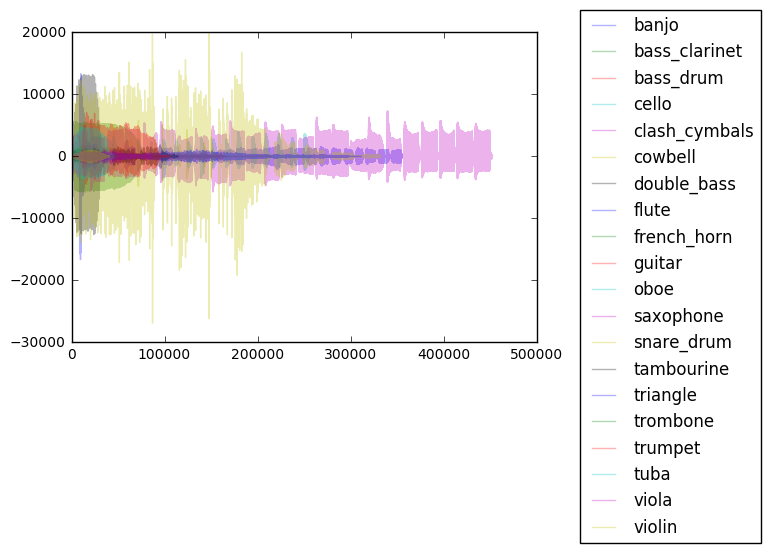

In [4]:
# Plot out all audio samples

import matplotlib.pyplot as plt
   
for instrument in instruments:
    plt.plot(instrument.data[0], label=instrument.name, alpha=0.3)
    
plt.legend(bbox_to_anchor=(1.5, 1.1))
plt.show()

## Multilayer Perceptron

In [5]:
# Prep Data
from sklearn.model_selection import train_test_split

X = []
y = []

for instrument in instruments:
    #print(instrument.name,'instrument.segments:',len(instrument.segments))
    for segments in instrument.segments:
        #print('\t segments length:',len(segments))
        for segment in segments:
            X.append(segment)
            y.append(instrument.name)
            #print('\t\t segment length:',len(segment))
    
X = np.array(X) 
y = np.array(y)

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

print('Data was captured!')

Data was captured!


In [6]:
# sklean Multilayer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

net = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

net.fit(X_train,y_train)
predictions = net.predict(X_test)

print('Accuracy on Train Set:', net.score(X_train,y_train))
print('Accuracy on Test Set:', net.score(X_test,y_test))
print('F1 Score:', f1_score(y_test,predictions,average='micro'))

Accuracy on Train Set: 0.344325800844301
Accuracy on Test Set: 0.3440235408053041
F1 Score: 0.3440235408053041


In [7]:
# Cross Validate Results
from sklearn.model_selection import cross_val_score

k = 3
scores = cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=(5, 2), random_state=1), 
                         X, y, cv=k)
print(str(k) + '-Fold Score: ' + str(np.mean(scores)) + " (" + str(scores) + ")")

3-Fold Score: 0.3365282866904147 ([0.36820201 0.31904017 0.32234268])


## Confusion Matrix for Neural Network

Confusion matrix, without normalization
[[ 255    0    0    0    0    0    0    0    0 1225    0  201    0    0
     0  307    0    0    0    0]
 [  39    2    1    0    0    0    0    0    0   44    0 1158    0    0
     0  917    0    0    0    0]
 [   3    2    0    0    0    0    0    0    3   14    0  995    0    0
     0  260    0    0    0    0]
 [  73    0    0    0    0    0    0    0    0  144    0   65    0    0
     0  625    0    0    0    0]
 [   4    0    0    0    0    0    0    0    1    2    0  270    0    0
     0   18    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  133    0    0
     0    5    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  816    0    0
     0   20    0    0    0    0]
 [  47    0    0    0    0    0    0    0    0   95    0  263    0    0
     0  397    0    0    0    0]
 [  14    0    0    0    0    0    0    0    9  706    0    0    0    0
     0   14    0    0    0    0]
 [ 191    0    

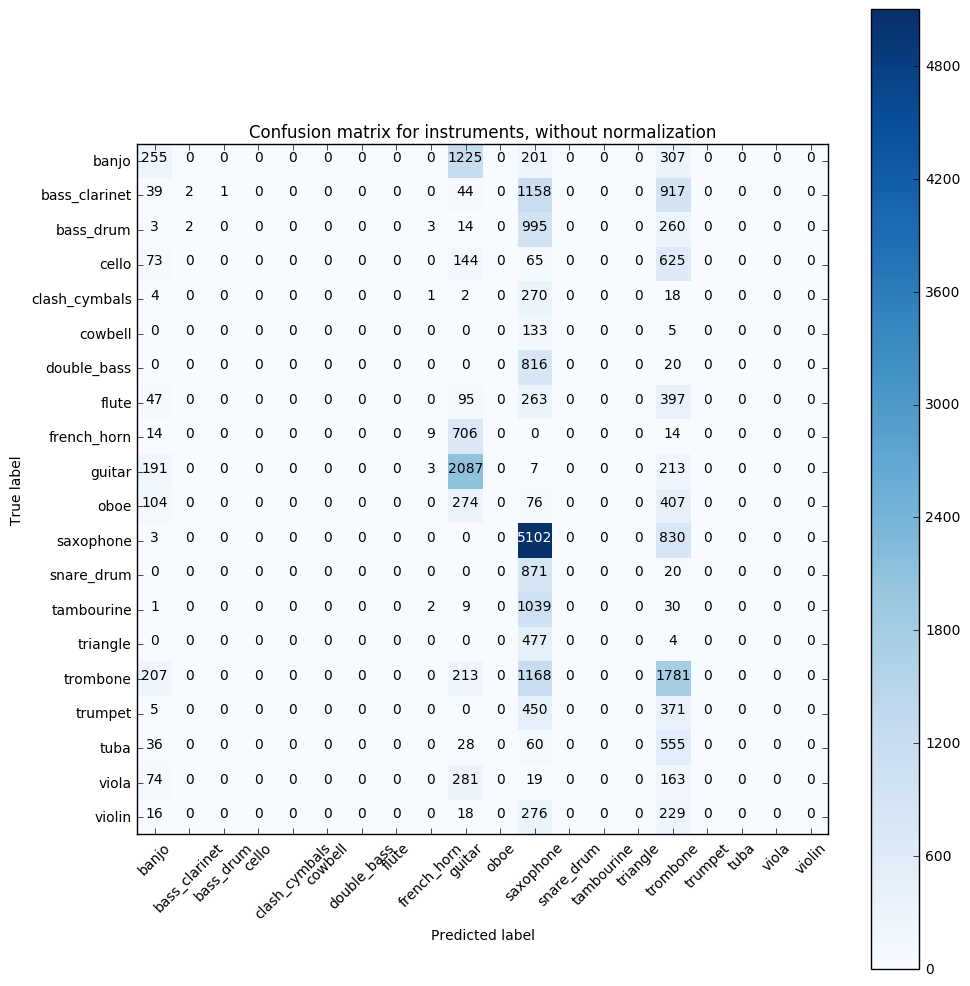

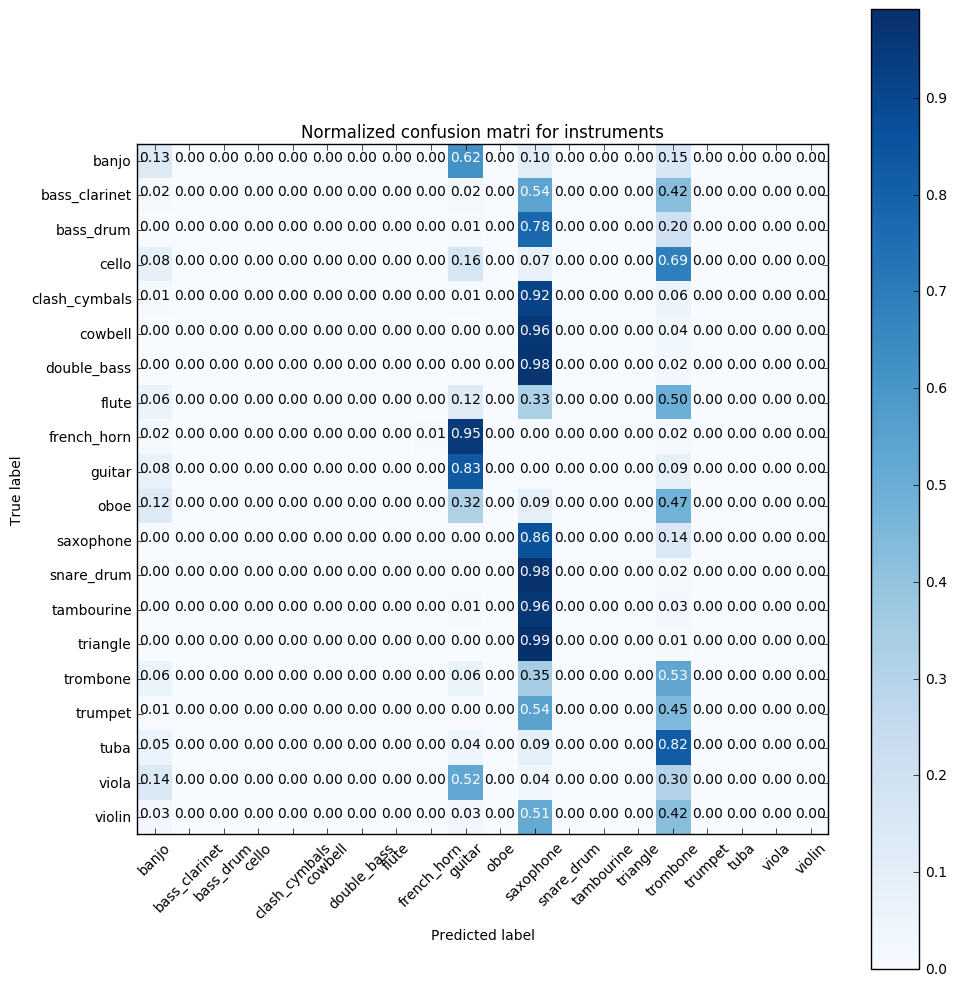

In [8]:
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

instrument_names = [instrument.name for instrument in instruments]

plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=instrument_names,
                      title = 'Confusion matrix for instruments, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=instrument_names, normalize=True,
                      title = 'Normalized confusion matri for instruments')
        
plt.show()

## Guess Instrument with Neural Network

In [9]:
def guess_instrument_nn(wav_file_path):
    rate, data = sp.read(wav_file_path)
    
    Zxx = stft_custom(data, rate)
    Zxx = abs(Zxx)
    segments = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
    
    guess_per_seg = list(net.predict(segments))
    
    final_guess = max(set(guess_per_seg), key=guess_per_seg.count)
    print("Final Guess: " + final_guess+'\n')
    print(guess_per_seg)

In [13]:
snare_drum = "data/wav_data/snare_drum/407.wav"
snare_drum2 = "data/wav_data/snare_drum/Mono Little Perc-408.wav"
saxophone = "data/wav_data/saxophone/Audio 5_04.wav"
trombone = "data/wav_data/trombone/Trombone Mono-135.L.wav"
tuba = "data/wav_data/tuba/Tuba Mono-66.wav"
violin = "data/wav_data/violin/0360.wav"
french_horn = "data/wav_data/french_horn/2 1.wav"
cello = "data/wav_data/cello/118.wav"
guitar = "data/wav_data/guitar/028.wav"

sad_violin = "data/wav_data/Sad_Violin.wav"

guess_instrument_nn(guitar)

Final Guess: guitar

['guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'trombone', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'banjo', 'trombone', 'trombone', 'trombone', 'trombone', 'banjo', 'trombone', 'trombone', 'trombone', 'banjo', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'banjo', 'banjo', 'guitar', 'trombone', 'banjo', 'banjo', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar

## Create Codebooks/Clusters for each instrument
- Clusters are generated with K-Means

In [14]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Put all spectral vectors of all samples for each instrument into separate arrays
clusters = {}
for instrument in instruments:
    spectral_vectors = []
    for Zxx in instrument.segments:
        for spectral_vector in Zxx:
            spectral_vectors.append(spectral_vector)
    clusters[instrument.name] = spectral_vectors
print("Captured Spectral Vectors")   
    
for instrument_name, vectors in clusters.items():
    clusters[instrument_name] = KMeans(n_clusters = 512, random_state = 1).fit(vectors)
    print(instrument_name,"codebook created")
    
print("FINISHED")

Captured Spectral Vectors
viola codebook created
cowbell codebook created
snare_drum codebook created
violin codebook created
tuba codebook created
french_horn codebook created
oboe codebook created
guitar codebook created
bass_clarinet codebook created
tambourine codebook created
clash_cymbals codebook created
banjo codebook created
trombone codebook created
triangle codebook created
trumpet codebook created
saxophone codebook created
double_bass codebook created
bass_drum codebook created
flute codebook created
cello codebook created
FINISHED


In [12]:
# Now use your test data---for each speaker randomly assign 10% of data as the test---
# and compare the test spectral vectors of the input speaker to m codebooks of each
# speaker.
for instrument in instruments:
    closest_instruments = {}
    X = []
    y = []
    for Zxx in instrument.segments:
        for spectral_vector in Zxx:
            X.append(spectral_vector)
            y.append(instrument.name)
    X = np.array(X) 
    y = np.array(y)
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    # Find the speaker whose spectral vector distant of its codebooks to the input spectral
    # vectors is minimum. And select that speaker as the identified speaker from your
    # machine.
    for instrument_name, cluster in clusters.items():
        #indices of closest cluster per segment in X
        cluster_indices = cluster.predict(X_test)
        #calculate distances from segment point 
        closest_cluster_center_coordinates=[cluster.cluster_centers_[i] for i in cluster_indices]
        for i in range(0, len(closest_cluster_center_coordinates)):
            a = X_test[i]
            b = closest_cluster_center_coordinates[i]
            distance = np.linalg.norm(b-a)
            if i not in closest_instruments.keys():
                closest_instruments[i] = (instrument_name, distance)
            if distance < closest_instruments[i][1]:
                closest_instruments[i] = (instrument_name, distance)
    guess_per_seg = ([closest_instrument[0] for closest_instrument in closest_instruments.values()])
    final_guess = max(set(guess_per_seg), key=guess_per_seg.count)
    print("Final Guess: " + final_guess + ", Actual Instrument: " + instrument.name)

AttributeError: 'list' object has no attribute 'predict'

## Guess Instruments with 512-Means Codebooks

In [ ]:
def guess_instrument_kmeans(wav_file_path):
    rate, data = sp.read(wav_file_path)
    
    overlap = rate/1000*10
    overlap = int(overlap)
    
    window_size = rate/1000*25
    window_size = int(window_size)
    
    Zxx = stft_custom(data, rate)
    
    Zxx = abs(Zxx)
    segments = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
    
    closest_instruments = {}
    for instrument_name, cluster in clusters.items():
        #indices of closest cluster per segment in segments
        cluster_indices = cluster.predict(segments)
        #calculate distances from segment point 
        closest_cluster_center_coordinates=[cluster.cluster_centers_[i] for i in cluster_indices]
        for i in range(0, len(closest_cluster_center_coordinates)):
            a = segments[i]
            b = closest_cluster_center_coordinates[i]
            distance = np.linalg.norm(b-a)
            if i not in closest_instruments.keys():
                closest_instruments[i] = (instrument_name, distance)
            if distance < closest_instruments[i][1]:
                closest_instruments[i] = (instrument_name, distance)
    guess_per_seg = ([closest_instrument[0] for closest_instrument in closest_instruments.values()])
    #print(guess_per_seg)
    final_guess = max(set(guess_per_seg), key=guess_per_seg.count)
    print("Final Guess: " + final_guess)

In [ ]:
snare_drum = "data/wav_data/snare_drum/407.wav"
snare_drum2 = "data/wav_data/snare_drum/Mono Little Perc-408.wav"
saxophone = "data/wav_data/saxophone/Audio 5_04.wav"
trombone = "data/wav_data/trombone/Trombone Mono-135.L.wav"
tuba = "data/wav_data/tuba/Tuba Mono-66.wav"
violin = "data/wav_data/violin/0360.wav"
french_horn = "data/wav_data/french_horn/2 1.wav"
cello = "data/wav_data/cello/118.wav"
guitar = "data/wav_data/guitar/028.wav"

sad_violin = "data/wav_data/Sad_Violin.wav"

guess_instrument_kmeans(violin)